## Tutorial on Minimum Variance Distortionless Reponse (MVDR) Beamformer.

Tutorial on built-in TorchAudio MVDR beamformer [here](https://pytorch.org/audio/stable/tutorials/mvdr_tutorial.html)\
Tutorial on MVDR from [this blog](https://nateanl.github.io/2021/07/21/mvdr-tutorial/)


In [1]:
import torch
import torchaudio
import torchaudio.functional as F

print(torch.__version__)
print(torchaudio.__version__)

2.0.0
2.0.1


In [3]:
# When running this example in notebook, install the following packages.
# !pip3 install mir_eval
# !pip3 install pesq
# !pip3 install pystoi

from pesq import pesq
from pystoi import stoi
import mir_eval

import matplotlib.pyplot as plt
from IPython.display import Audio
from torchaudio.utils import download_asset

The multi-channel audio example is selected from ConferencingSpeech dataset.

The original filename is
- `SSB07200001\#noise-sound-bible-0038\#7.86_6.16_3.00_3.14_4.84_134.5285_191.7899_0.4735\#15217\#25.16333303751458\#0.2101221178590021.wav`

which was generated with:
- `SSB07200001.wav` from AISHELL-3 (Apache License v.2.0)
- `noise-sound-bible-0038.wav` from MUSAN (Attribution 4.0 International — CC BY 4.0)

In [4]:
SAMPLE_RATE = 16000
SAMPLE_CLEAN = download_asset("tutorial-assets/mvdr/clean_speech.wav")
SAMPLE_NOISE = download_asset("tutorial-assets/mvdr/noise.wav")

100%|██████████| 0.98M/0.98M [00:00<00:00, 10.4MB/s]
100%|██████████| 1.95M/1.95M [00:00<00:00, 8.05MB/s]


In [5]:
def plot_spectrogram(stft, title="Spectrogram", xlim=None):
    magnitude = stft.abs()
    spectrogram = 20 * torch.log10(magnitude + 1e-8).numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(spectrogram, cmap="viridis", vmin=-100, vmax=0, origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()


def plot_mask(mask, title="Mask", xlim=None):
    mask = mask.numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()


def si_snr(estimate, reference, epsilon=1e-8):
    estimate = estimate - estimate.mean()
    reference = reference - reference.mean()
    reference_pow = reference.pow(2).mean(axis=1, keepdim=True)
    mix_pow = (estimate * reference).mean(axis=1, keepdim=True)
    scale = mix_pow / (reference_pow + epsilon)

    reference = scale * reference
    error = estimate - reference

    reference_pow = reference.pow(2)
    error_pow = error.pow(2)

    reference_pow = reference_pow.mean(axis=1)
    error_pow = error_pow.mean(axis=1)

    si_snr = 10 * torch.log10(reference_pow) - 10 * torch.log10(error_pow)
    return si_snr.item()


def generate_mixture(waveform_clean, waveform_noise, target_snr):
    power_clean_signal = waveform_clean.pow(2).mean()
    power_noise_signal = waveform_noise.pow(2).mean()
    current_snr = 10 * torch.log10(power_clean_signal / power_noise_signal)
    waveform_noise *= 10 ** (-(target_snr - current_snr) / 20)
    return waveform_clean + waveform_noise


def evaluate(estimate, reference):
    si_snr_score = si_snr(estimate, reference)
    (
        sdr,
        _,
        _,
        _,
    ) = mir_eval.separation.bss_eval_sources(reference.numpy(), estimate.numpy(), False)
    pesq_mix = pesq(SAMPLE_RATE, estimate[0].numpy(), reference[0].numpy(), "wb")
    stoi_mix = stoi(reference[0].numpy(), estimate[0].numpy(), SAMPLE_RATE, extended=False)
    print(f"SDR score: {sdr[0]}")
    print(f"Si-SNR score: {si_snr_score}")
    print(f"PESQ score: {pesq_mix}")
    print(f"STOI score: {stoi_mix}")

In [6]:
# Load audio data

waveform_clean, sr = torchaudio.load(SAMPLE_CLEAN)
waveform_noise, sr2 = torchaudio.load(SAMPLE_NOISE)
assert sr == sr2 == SAMPLE_RATE
# The mixture waveform is a combination of clean and noise waveforms with a desired SNR.
target_snr = 3
waveform_mix = generate_mixture(waveform_clean, waveform_noise, target_snr)
# To improve computational robustness, represent the waveforms as double-precision floating point
waveform_mix = waveform_mix.to(torch.double)
waveform_clean = waveform_clean.to(torch.double)
waveform_noise = waveform_noise.to(torch.double)

In [7]:
N_FFT = 1024
N_HOP = 256
stft = torchaudio.transforms.Spectrogram(
    n_fft=N_FFT,
    hop_length=N_HOP,
    power=None,
)
istft = torchaudio.transforms.InverseSpectrogram(n_fft=N_FFT, hop_length=N_HOP)

stft_mix = stft(waveform_mix)
stft_clean = stft(waveform_clean)
stft_noise = stft(waveform_noise)

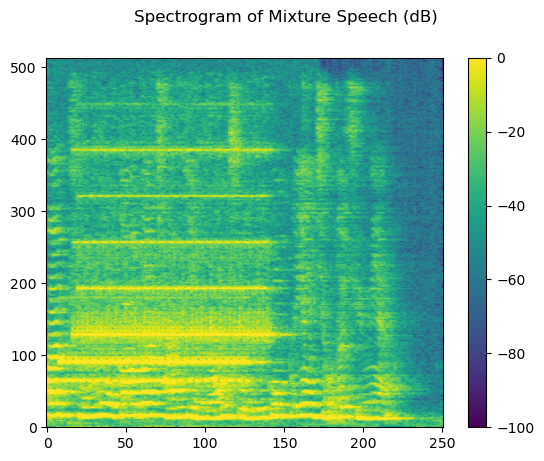

SDR score: 4.140362181778024
Si-SNR score: 4.104058905536078
PESQ score: 2.0084526538848877
STOI score: 0.7724339398714715


In [8]:
# Plots the spectrogram of the speech-noise mix
plot_spectrogram(stft_mix[0], "Spectrogram of Mixture Speech (dB)")
evaluate(waveform_mix[0:1], waveform_clean[0:1])
Audio(waveform_mix[0], rate=SAMPLE_RATE)

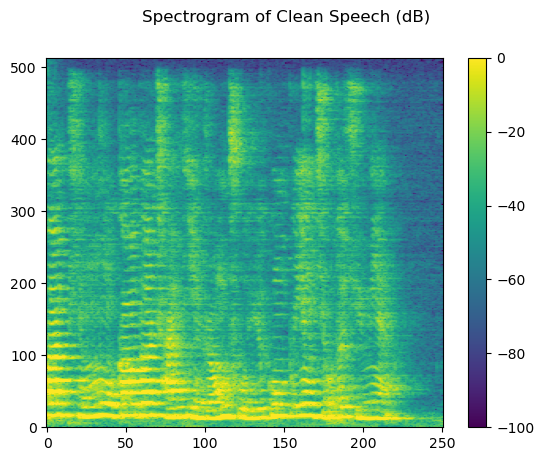

In [9]:
# Plot of clean signal
plot_spectrogram(stft_clean[0], "Spectrogram of Clean Speech (dB)")
Audio(waveform_clean[0], rate=SAMPLE_RATE)

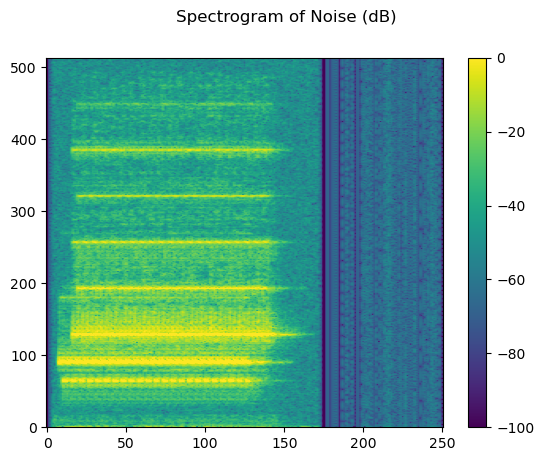

In [10]:
# Plot interference "noise"
plot_spectrogram(stft_noise[0], "Spectrogram of Noise (dB)")
Audio(waveform_noise[0], rate=SAMPLE_RATE)

### Define reference channel
Get Ideal Ratio Mask [(IRM)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4293540/pdf/nihms642326.pdf) of clean signal and noise
IRMs will be used to evaluate signal separation performance. 
$$ IRM(X|Y) = \frac{|X|^2}{|X|^2+|Y|^2} $$ 
where $$X = \mathcal{F}(x)$$ (FFT of x)

In [11]:
REFERENCE_CHANNEL = 0
def get_irms(stft_clean, stft_noise):
    mag_clean = stft_clean.abs() ** 2 # magnitude of clean speech STFT |F|^2
    mag_noise = stft_noise.abs() ** 2 # magnitude of interference only "noise" STFT |F|^2
    irm_speech = mag_clean / (mag_clean + mag_noise)
    irm_noise = mag_noise / (mag_clean + mag_noise)
    return irm_speech[REFERENCE_CHANNEL], irm_noise[REFERENCE_CHANNEL]


irm_speech, irm_noise = get_irms(stft_clean, stft_noise)

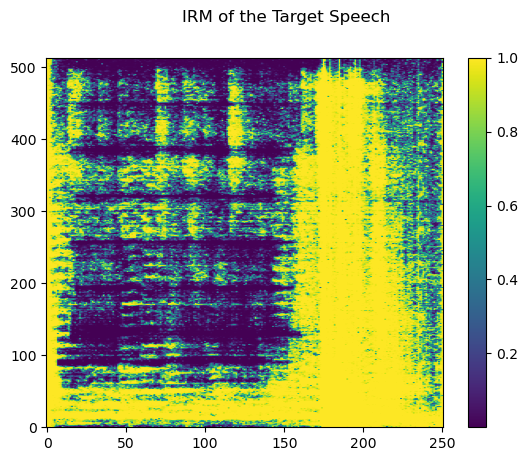

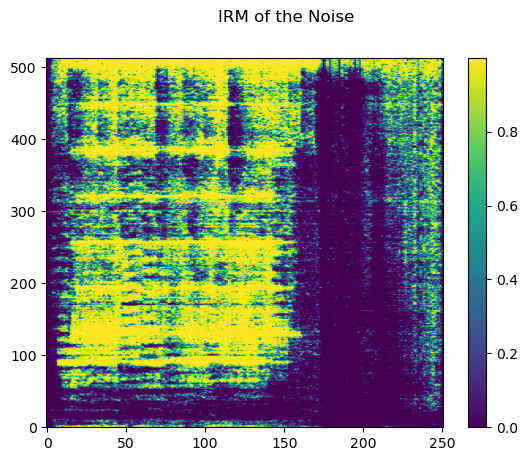

In [12]:
# Plot IRMs
plot_mask(irm_speech, "IRM of the Target Speech")
plot_mask(irm_noise, "IRM of the Noise")

In [13]:
# Compute Power Spectral Density of speech and noise
psd_transform = torchaudio.transforms.PSD()

psd_speech = psd_transform(stft_mix, irm_speech)
psd_noise = psd_transform(stft_mix, irm_noise)

In [14]:
# Apply Souden MVDR beamforming
mvdr_transform = torchaudio.transforms.SoudenMVDR()
stft_souden = mvdr_transform(stft_mix, psd_speech, psd_noise, reference_channel=REFERENCE_CHANNEL)
waveform_souden = istft(stft_souden, length=waveform_mix.shape[-1])

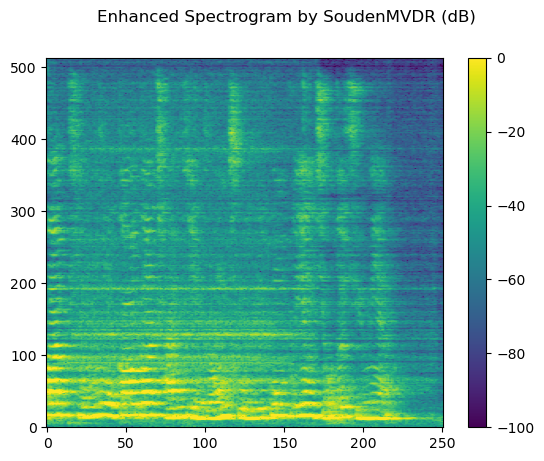

SDR score: 17.946234445047246
Si-SNR score: 12.215202647489498
PESQ score: 3.344752788543701
STOI score: 0.8712864447044812
Souden beamformed:
Mixed Signal and Interference


In [16]:
# Plot Souden MVDR Beamformed spectrum
plot_spectrogram(stft_souden, "Enhanced Spectrogram by SoudenMVDR (dB)")
waveform_souden = waveform_souden.reshape(1, -1)
evaluate(waveform_souden, waveform_clean[0:1])


In [17]:
print('Souden beamformed:')
Audio(waveform_souden, rate=SAMPLE_RATE)


Souden beamformed:


In [18]:
print('Mixed Signal and Interference')
Audio(waveform_mix[0], rate=SAMPLE_RATE)

Mixed Signal and Interference


torch.Size([513, 8])

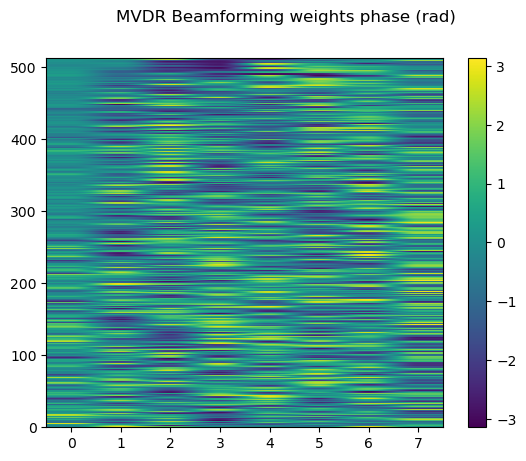

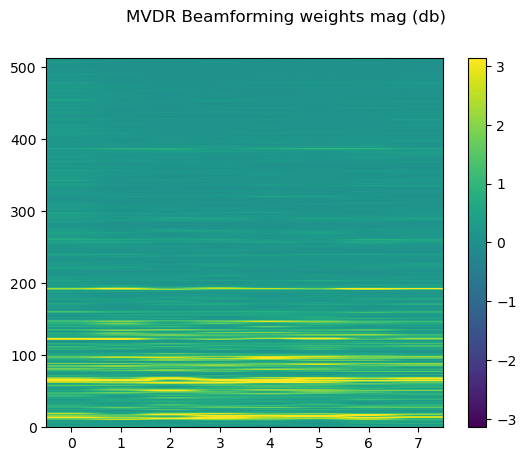

In [48]:
# Plot beamforming weights

#       specgram: Tensor,
#       psd_s: Tensor,
#       psd_n: Tensor,
#       reference_channel: Union[int, Tensor],
#       diagonal_loading: bool = True,
#       diag_eps: float = 1e-7,
#       eps: float = 1e-8,
# stft_souden = mvdr_transform(stft_mix, psd_speech, psd_noise, reference_channel=REFERENCE_CHANNEL)
# waveform_souden = istft(stft_souden, length=waveform_mix.shape[-1])

w_mvdr = F.mvdr_weights_souden(psd_speech, psd_noise, REFERENCE_CHANNEL, True, 1e-7, 1e-8)
        # spectrum_enhanced = F.apply_beamforming(w_mvdr, specgram)
figure, axis = plt.subplots(1, 1)
img = axis.imshow(torch.angle(w_mvdr), cmap="viridis", vmin=-torch.pi, vmax=torch.pi, origin="lower", aspect="auto")
figure.suptitle("MVDR Beamforming weights phase (rad)")
plt.colorbar(img, ax=axis)

figure, axis = plt.subplots(1, 1)
img = axis.imshow(torch.abs(w_mvdr), cmap="viridis", vmin=-torch.pi, vmax=torch.pi, origin="lower", aspect="auto")
figure.suptitle("MVDR Beamforming weights mag (db)")
plt.colorbar(img, ax=axis)
# w_mvdr.shape
# plt.figure()
# plt.plot(torch.abs(w_mvdr[0:10,:]))
# plt.title("MVDR weights magnitude(dB)")
# plt.figure()
# plt.plot(torch.angle(w_mvdr[0:10,:]))
# plt.title("MVDR Beamforming weights phase (rad)")
# # stft_mix.shape
# # waveform_clean.shape
w_mvdr.shape


Text(0, 0.5, 'In Frequency')

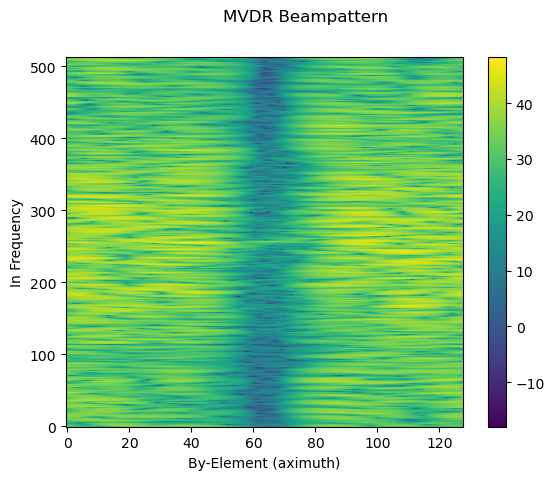

In [63]:
w_mvdr = F.mvdr_weights_souden(psd_speech, psd_noise, REFERENCE_CHANNEL, True, 1e-7, 1e-8)
Zp = 16
mvdr_spect = torch.fft.fft2(w_mvdr,(w_mvdr.shape[0],w_mvdr.shape[1]*Zp))

figure, axis = plt.subplots(1, 1)
img = axis.imshow(20*torch.log10(torch.abs(torch.fft.fftshift(mvdr_spect))), cmap="viridis",  origin="lower", aspect="auto")
figure.suptitle("MVDR Beampattern")
plt.colorbar(img, ax=axis)
plt.xlabel('By-Element (aximuth)')
plt.ylabel('In Frequency')

torch.Size([513, 8])


tensor([  13.4380-6.7502e-14j,    3.4787-3.9215e+01j,  -25.0977-7.1284e+01j,
         -68.5534-8.9980e+01j, -121.1986-9.0801e+01j, -176.1274-7.1550e+01j,
        -226.1137-3.2616e+01j, -264.5517+2.3077e+01j, -286.3190+9.0450e+01j,
        -288.4523+1.6294e+02j, -270.5438+2.3336e+02j, -234.8061+2.9488e+02j,
        -185.7916+3.4189e+02j, -129.7984+3.7086e+02j,  -74.0334+3.8077e+02j,
         -25.6376+3.7336e+02j,    9.3047+3.5291e+02j,   26.6439+3.2576e+02j,
          24.8149+2.9952e+02j,    5.1689+2.8201e+02j,  -28.0658+2.8026e+02j,
         -68.1987+2.9946e+02j, -106.8305+3.4218e+02j, -134.8586+4.0786e+02j,
        -143.6201+4.9265e+02j, -126.0333+5.8969e+02j,  -77.5972+6.8978e+02j,
           2.8790+7.8238e+02j,  112.9172+8.5676e+02j,  246.4370+9.0330e+02j,
         394.2590+9.1467e+02j,  544.9972+8.8685e+02j,  686.2503+8.1970e+02j,
         805.9608+7.1720e+02j,  893.7884+5.8719e+02j,  942.3360+4.4062e+02j,
         948.0825+2.9045e+02j,  911.9031+1.5030e+02j,  839.1063+3.2920e+01j,

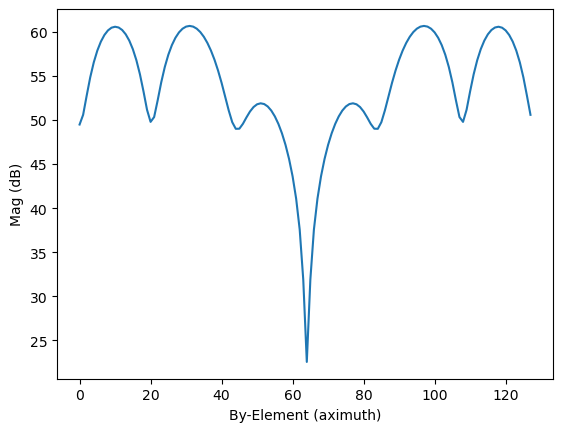

In [75]:
w_mvdr = F.mvdr_weights_souden(psd_speech, psd_noise, REFERENCE_CHANNEL, True, 1e-7, 1e-8)
print(w_mvdr.shape)
Zp = 16
mvdr_spect = torch.fft.fft2(w_mvdr,(w_mvdr.shape[0],w_mvdr.shape[1]*Zp))
mvdr_spect_element = torch.sum(mvdr_spect,0)

#s = 20*torch.log10(torch.abs(torch.fft.fftshift(mvdr_spect))).transpose(0,1)[:,:5]
s = 20*torch.log10(torch.abs(torch.fft.fftshift(mvdr_spect_element)))

plt.figure()
plt.plot(s)
plt.xlabel('By-Element (aximuth)')
plt.ylabel('Mag (dB)')
mvdr_spect_element